# LAB3 - Uczenie sieci neuronowych z wykorzystaniem GPU
ver: 6

Przedmiot: _Sztuczna Inteligencja w Systemach Informatycznych_

Autor: Tomasz Szydło

kontakt: tszydlo@agh.edu.pl

Celem laboratorium jest porównanie czasu uczenia sieci neuronowych z wykorzystaniem CPU oraz GPU. Przedmiotem uczenia będzie sieć rozpoznająca cyfry pisane odręcznie. W procesie uczenia zostanie wykorzystany zbiór MNIST:

http://yann.lecun.com/exdb/mnist/


Laboratorium może być zrealizowane w dwóch środowiskach pracy:
 * Google Colab w chmurze obliczeniowej;
 * lokalnie na komputerze wyposażonym w GPU.


## Środowisko pracy - Google Codelab

https://codelabs.developers.google.com/?cat=Machine+Learning

Dostęp do notatnika: https://colab.research.google.com

Włączenie/wyłączenie wsparcia GPU odbywa się poprzez zmianę opcji środowiska uruchomieniowego:
 * Runtime -> Change runtime type -> Hardware accelerator -> None/GPU


## Środowisko pracy - PC + GPU/CUDA + Anaconda

Realizacja laboratorium wymaga Anacondy ze środowiskami:
 * tensorflow
 * tensorflow_gpuenv

Różnica pomiędzy nimi polega na wykorzystaniu implementacji biblioteki Tensorflow z NVidia CUDA.

Tworzenie środowisk:
 * wersja z CPU:

```
conda create -n tensorflow_env tensorflow
conda activate tensorflow_env
```

 * wersja z GPU:

```
conda create -n tensorflow_gpuenv tensorflow-gpu
conda activate tensorflow_gpuenv
```

Za pomocą Anaconda Navigator uruchamiamy Jupyter Notebook w konkretnym środowisku - tylko CPU lub ze wsparciem GPU.


## Sieć neuronowa dla zbioru MNIST

Przygotowanie środowiska - należy uruchomić notatnik z obliczeniami wyłącznie na CPU.

In [6]:
try:
  %tensorflow_version 2.x
except:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, AveragePooling2D
from keras.utils import to_categorical
#labels = to_categorical(labels)

plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

In [8]:
physical_devices = tensorflow.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [9]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

11490434/11490434 [==============================] - 0s 0us/step
X_train original shape (60000, 28, 28)
y_train original shape (60000,)


Zwizualizuj przykładowe dane.

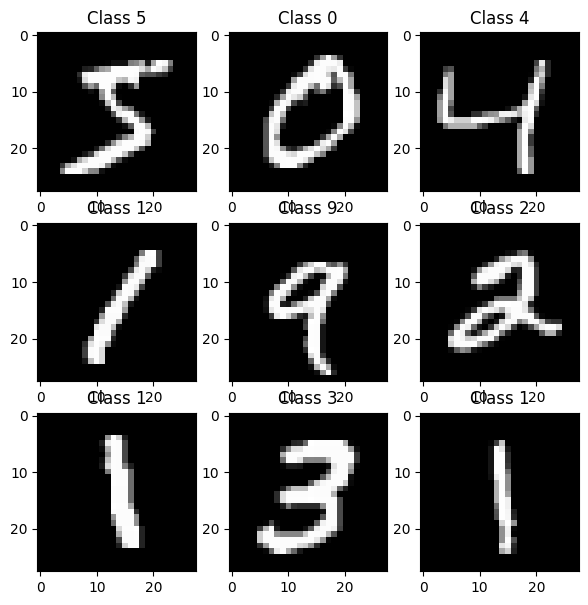

In [10]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

Sieć neuronowa przyjmuje na wejściu obrazek z jednym kanałem - poziomem jasności, więc konieczne jest przekształcenie danych wejściowych, aby każdy obraz 28 x 28 stał się macierzą 28 x 28 x 1.

Skalujemy również dane wejściowe w zakresie [0–1] zamiast [0–255]

In [11]:
X_train.shape

(60000, 28, 28)

In [12]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


Zmodyfikuj macierze wyjść korzystając z techniki One Hot Encoding, tj.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
```
itp.

In [13]:
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test )

In [14]:
Y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#Sieć MLP
Zbuduj sieć neuronową. Na potrzeby zajęć sieć będzie posiadała 2 w pełni połączone warstwy. Na wejściu sieci jest macierz z jednym kanałem (28,28,1) dlatego pierwsza warstwa to *Flatten()*.

In [15]:
Y_test.shape

(10000, 10)

In [16]:
model_mlp = Sequential()
model_mlp.add(Flatten(input_shape=(28,28,)))
model_mlp.add(Dense(512, input_shape=(784,)))
model_mlp.add(Activation('relu'))
model_mlp.add(Dropout(0.2))   # pomaga chronić model przed „nadmiernym dopasowaniem”

model_mlp.add(Dense(512))
model_mlp.add(Activation('relu'))
model_mlp.add(Dropout(0.2))

model_mlp.add(Dense(10))
model_mlp.add(Activation('softmax')) # w celu zapewnienia rozkładu wyjść sumującego się do 1

#Sieć CNN
Zbuduj sieć neuronową. Powinna to być sieć LeNet-5 ze zmodyfikowanym rozmiarem wejścia (28,28,1) zamiast (32,32,1).

In [17]:
model_cnn = Sequential()
model_cnn.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))

# Warstwa 2: pooling
model_cnn.add(AveragePooling2D())

# Warstwa 3: konwolucyjna (filtrów: 16, rozmiar filtra: 3x3)
model_cnn.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))

# Warstwa 4: pooling
model_cnn.add(AveragePooling2D())

# Warstwa 5: spłaszczająca
model_cnn.add(Flatten())

# Warstwa 6: w pełni połączona (liczba neuronów: 120)
model_cnn.add(Dense(units=120, activation='relu'))

# Warstwa 7: w pełni połączona (liczba neuronów: 84)
model_cnn.add(Dense(units=84, activation='relu'))

# Warstwa 8: wyjściowa warstwa w pełni połączona (liczba neuronów: 10)
model_cnn.add(Dense(units=10, activation = 'softmax'))



#Kompilacja modelu

Kolejnym krokiem jest kompilacja modelu. Biblioteka Keras jest wysokopoziomowym API upraszczającym tworzenie i uczenie sieci neuronowych z wykorzystaniem biblitoeki Tensorflow. Podczas kompilacji sieci, biblioteka Keras wymaga określenia funkcji strat oraz algorytmu optymalizującego proces uczenia.

In [18]:
def compile_model(model):
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model.summary()

Po kompilacji modelu sieci neuronowej można przystąpić do uczenia sieci. Ze względu na fakt, że Jupyter notebook został uruchiomy w środowisku z biblioteką Tensorflow bez wsparcia dla GPU, to obliczenia będa wykonywane tylko i wyłącznie na CPU.

In [19]:
import time
import keras
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


In [20]:
def fit_model(model):
  model.fit(X_train, Y_train,
            batch_size=128, epochs=16,
            verbose=1,
            validation_data=(X_test, Y_test), callbacks = time_callback)
  return time_callback.times

## Ewaluacja sieci neuronowej dla zbioru MNIST

In [21]:
def evaluate_model(model):
  score = model.evaluate(X_test, Y_test,verbose=0)


  predicted_classes = np.argmax(model.predict(X_test), axis=-1)
  correct_indices = np.nonzero(predicted_classes == y_test)[0]
  incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

  plt.figure()
  for i, correct in enumerate(correct_indices[:9]):
      plt.subplot(3,3,i+1)
      plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
      plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))

  plt.figure()
  for i, incorrect in enumerate(incorrect_indices[:9]):
      plt.subplot(3,3,i+1)
      plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
      plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

  return score

## Analiza czasu uczenia sieci z wykorzystaniem CPU oraz przy wsparciu GPU

### CPU model MLP

In [17]:
time_callback = TimeHistory()
compile_model(model_mlp)
cpu_epoch_time_MLP = fit_model(model_mlp)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

In [33]:
print("Czasy trwania epok dla modelu MLP na CPU:")
for epoch, time in enumerate(cpu_epoch_time_MLP, start=1):
    print(f"Epoka {epoch}: {time:.2f} sekund")

Czasy trwania epok dla modelu MLP na CPU:
Epoka 1: 9.78 sekund
Epoka 2: 8.86 sekund
Epoka 3: 10.10 sekund
Epoka 4: 9.15 sekund
Epoka 5: 8.59 sekund
Epoka 6: 9.39 sekund
Epoka 7: 10.34 sekund
Epoka 8: 11.74 sekund
Epoka 9: 12.33 sekund
Epoka 10: 8.74 sekund
Epoka 11: 11.63 sekund
Epoka 12: 13.33 sekund
Epoka 13: 9.00 sekund
Epoka 14: 10.48 sekund
Epoka 15: 12.60 sekund
Epoka 16: 9.34 sekund


313/313 [==============================] - 1s 3ms/step
wyświetlenie przykładów poprawnych i niepoprawnych predykcji na zbiorze testowym


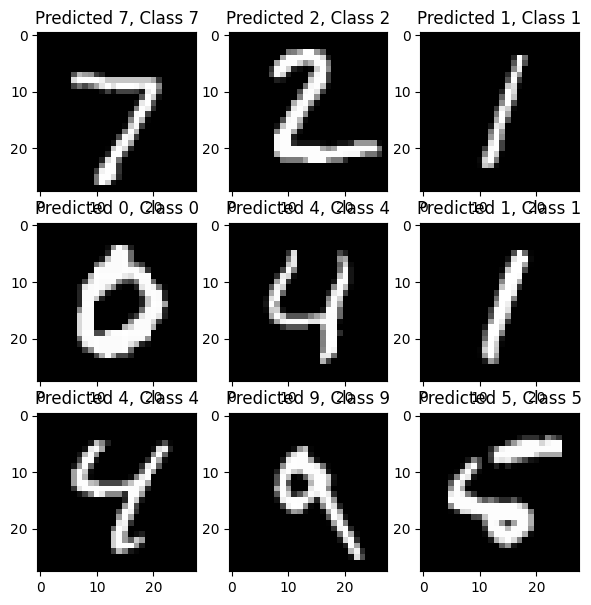

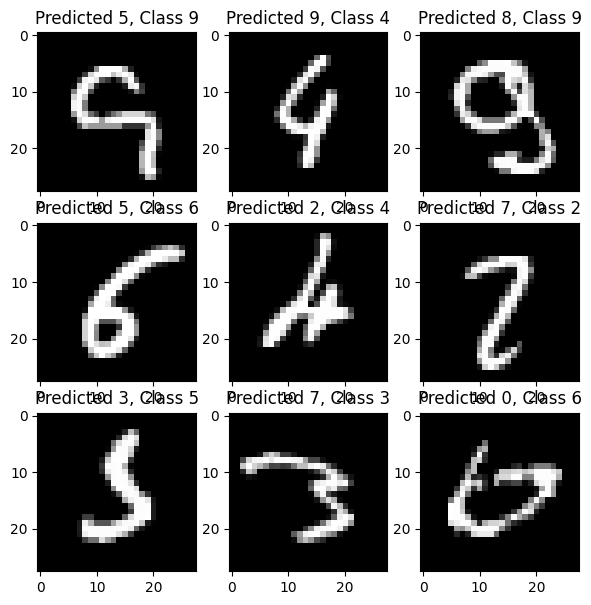

In [34]:
cpu_loss_MLP, cpu_accuracy_MLP = evaluate_model(model_mlp)
print("wyświetlenie przykładów poprawnych i niepoprawnych predykcji na zbiorze testowym")

In [35]:
print('CPU-MLP -> Loss: {:.4f}, Accuracy: {:.4f}'.format(cpu_loss_MLP, cpu_accuracy_MLP))

CPU-MLP -> Loss: 0.1029, Accuracy: 0.9823


### CPU model CNN

In [18]:
time_callback = TimeHistory()
compile_model(model_cnn)
cpu_epoch_time_CNN = fit_model(model_cnn)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 6)         60        
                                                                 
 average_pooling2d (Average  (None, 13, 13, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        880       
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [41]:
print("Czasy trwania epok dla modelu CNN na CPU:")
for epoch, time in enumerate(cpu_epoch_time_CNN, start=1):
    print(f"Epoka {epoch}: {time:.2f} sekund")

Czasy trwania epok dla modelu CNN na CPU:
Epoka 1: 18.92 sekund
Epoka 2: 16.56 sekund
Epoka 3: 15.91 sekund
Epoka 4: 17.80 sekund
Epoka 5: 15.55 sekund
Epoka 6: 15.93 sekund
Epoka 7: 16.34 sekund
Epoka 8: 16.27 sekund
Epoka 9: 15.81 sekund
Epoka 10: 15.93 sekund
Epoka 11: 18.06 sekund
Epoka 12: 16.01 sekund
Epoka 13: 18.25 sekund
Epoka 14: 21.88 sekund
Epoka 15: 21.64 sekund
Epoka 16: 17.24 sekund


313/313 [==============================] - 2s 8ms/step
wyświetlenie przykładów poprawnych i niepoprawnych predykcji na zbiorze testowym


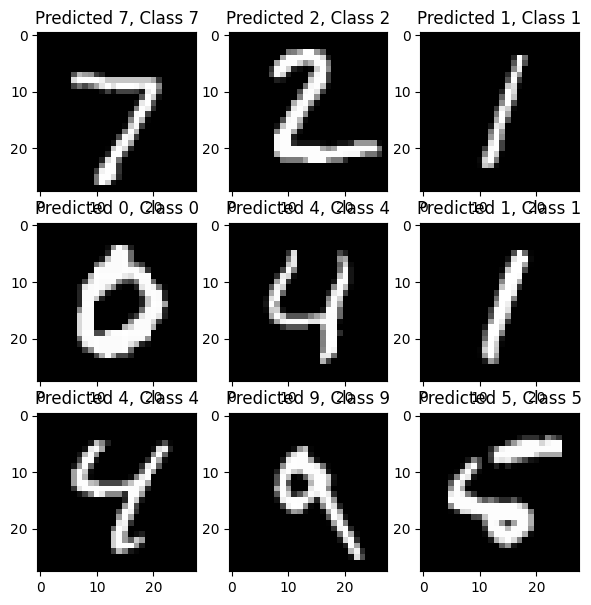

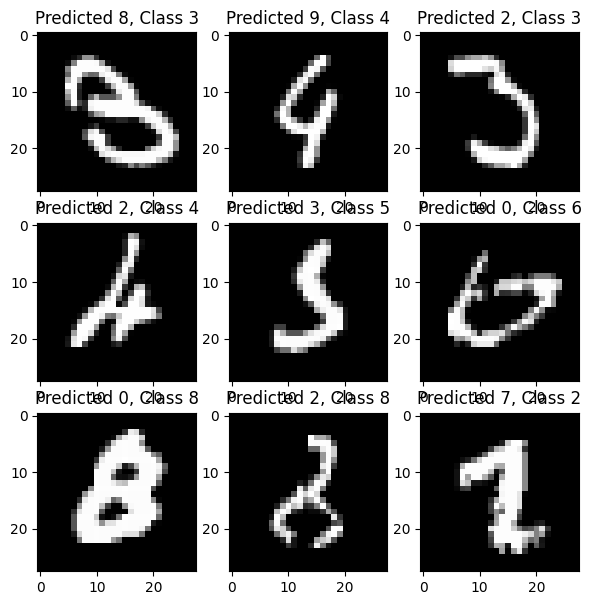

In [42]:
cpu_loss_CNN, cpu_accuracy_CNN = evaluate_model(model_cnn)
print("wyświetlenie przykładów poprawnych i niepoprawnych predykcji na zbiorze testowym")

In [43]:
print('CPU-CNN -> Loss: {:.4f}, Accuracy: {:.4f}'.format(cpu_loss_CNN, cpu_accuracy_CNN))

CPU-CNN -> Loss: 0.0338, Accuracy: 0.9903


Uaktywnij wsparcie GPU dla obliczeń i uruchom ponownie proces uczenia sieci neuronowej na bazie MNIST i uzupełnij fragment kodu poniżej.

W przypadku środowiska Anaconda zamknij środowisko *tensorflow\_env* i uruchom środowisko *tensorflow\_gpuenv*. W przypadku Google Colab zmień ustawienia środowiska uruchomieniowego.



### GPU model MLP

In [22]:
time_callback = TimeHistory()
compile_model(model_mlp)
gpu_epoch_time_MLP = fit_model(model_mlp)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

In [19]:
print("Czasy trwania epok dla modelu MLP na GPU:")
for epoch, time in enumerate(gpu_epoch_time_MLP, start=1):
    print(f"Epoka {epoch}: {time:.2f} sekund")

Czasy trwania epok dla modelu MLP na GPU:
Epoka 1: 6.90 sekund
Epoka 2: 2.04 sekund
Epoka 3: 2.63 sekund
Epoka 4: 1.86 sekund
Epoka 5: 2.82 sekund
Epoka 6: 3.26 sekund
Epoka 7: 3.38 sekund
Epoka 8: 3.73 sekund
Epoka 9: 2.60 sekund
Epoka 10: 2.95 sekund
Epoka 11: 3.35 sekund
Epoka 12: 3.05 sekund
Epoka 13: 2.52 sekund
Epoka 14: 2.32 sekund
Epoka 15: 2.71 sekund
Epoka 16: 2.90 sekund


313/313 [==============================] - 1s 2ms/step
wyświetlenie przykładów poprawnych i niepoprawnych predykcji na zbiorze testowym


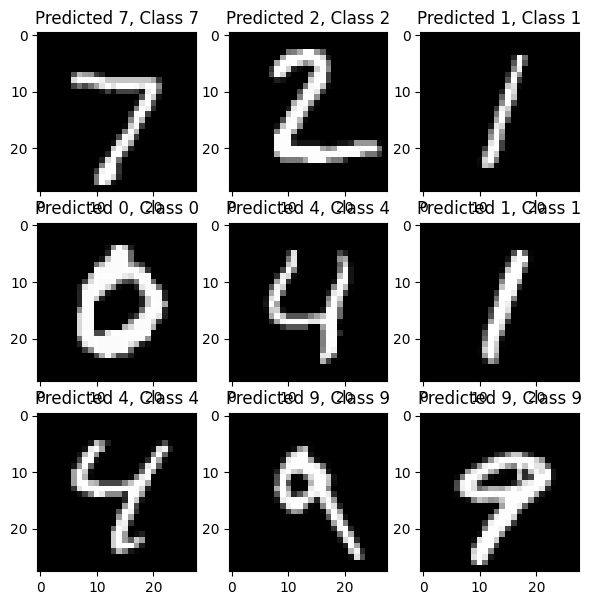

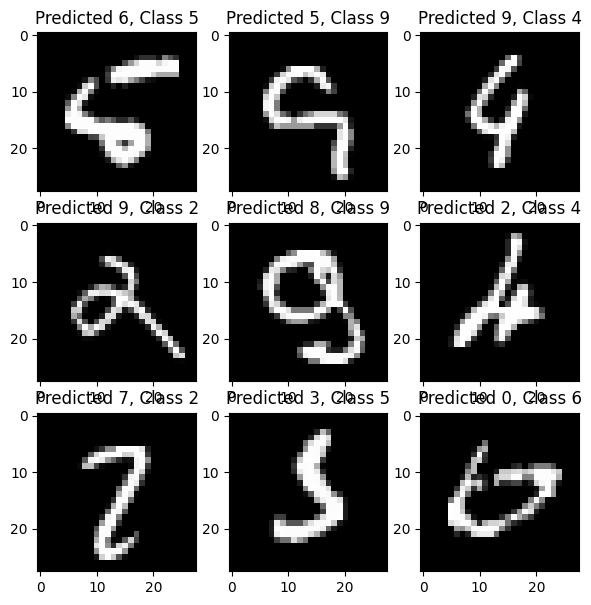

In [20]:
gpu_loss_MLP, gpu_accuracy_MLP = evaluate_model(model_mlp)
print("wyświetlenie przykładów poprawnych i niepoprawnych predykcji na zbiorze testowym")

In [21]:
print('GPU-MLP -> Loss: {:.4f}, Accuracy: {:.4f}'.format(gpu_loss_MLP, gpu_accuracy_MLP))

GPU-MLP -> Loss: 0.0816, Accuracy: 0.9821


### GPU model CNN

In [23]:
time_callback = TimeHistory()
compile_model(model_cnn)
gpu_epoch_time_CNN = fit_model(model_cnn)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 6)         60        
                                                                 
 average_pooling2d (Average  (None, 13, 13, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        880       
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [26]:
print("Czasy trwania epok dla modelu CNN na GPU:")
for epoch, time in enumerate(gpu_epoch_time_CNN, start=1):
    print(f"Epoka {epoch}: {time:.2f} sekund")

Czasy trwania epok dla modelu CNN na GPU:
Epoka 1: 6.05 sekund
Epoka 2: 2.19 sekund
Epoka 3: 2.36 sekund
Epoka 4: 2.51 sekund
Epoka 5: 2.25 sekund
Epoka 6: 2.12 sekund
Epoka 7: 2.28 sekund
Epoka 8: 2.23 sekund
Epoka 9: 3.30 sekund
Epoka 10: 2.36 sekund
Epoka 11: 2.14 sekund
Epoka 12: 2.25 sekund
Epoka 13: 2.11 sekund
Epoka 14: 2.78 sekund
Epoka 15: 2.21 sekund
Epoka 16: 2.10 sekund


313/313 [==============================] - 1s 2ms/step
wyświetlenie przykładów poprawnych i niepoprawnych predykcji na zbiorze testowym


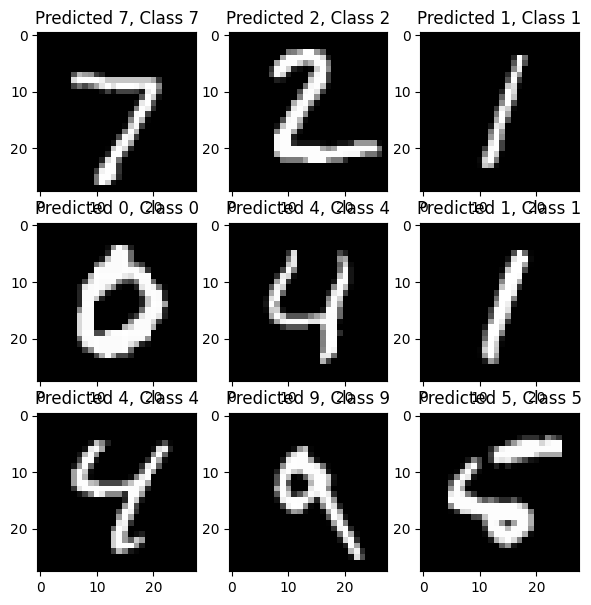

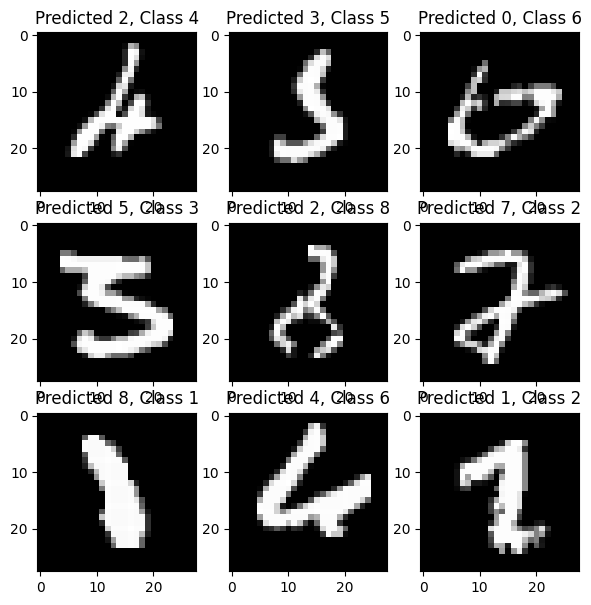

In [27]:
gpu_loss_CNN, gpu_accuracy_CNN = evaluate_model(model_cnn)
print("wyświetlenie przykładów poprawnych i niepoprawnych predykcji na zbiorze testowym")

In [28]:
print('GPU-CNN -> Loss: {:.4f}, Accuracy: {:.4f}'.format(gpu_loss_CNN, gpu_accuracy_CNN))

GPU-CNN -> Loss: 0.0366, Accuracy: 0.9896


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pickle

In [28]:
cpu_results = [cpu_epoch_time_MLP, cpu_epoch_time_CNN]
with open('/content/drive/MyDrive/Colab Notebooks/Sisi/Lab_3/cpu_results.pkl', 'wb') as f:
    pickle.dump(cpu_results, f)

In [4]:
with open('/content/drive/MyDrive/Colab Notebooks/Sisi/Lab_3/cpu_results.pkl', 'rb') as f:
    cpu_results = pickle.load(f)

In [24]:
gpu_results = [gpu_epoch_time_MLP, gpu_epoch_time_CNN]
with open('/content/gpu_results.pkl', 'wb') as f:
    pickle.dump(gpu_results, f)

In [25]:
with open('/content/gpu_results.pkl', 'rb') as f:
    gpu_results = pickle.load(f)

In [26]:
gpu_results[0]

[5.216361999511719,
 2.3284988403320312,
 2.1299312114715576,
 1.8514318466186523,
 1.8483893871307373,
 1.7171556949615479,
 1.8564045429229736,
 1.8672850131988525,
 2.3022561073303223,
 1.769063949584961,
 1.740713119506836,
 2.2613279819488525,
 2.0963375568389893,
 1.7081356048583984,
 2.206087112426758,
 2.5996897220611572]

Zwizualizuj i przeanalizuj czas uczenia sieci neuronowej z CPU i GPU.

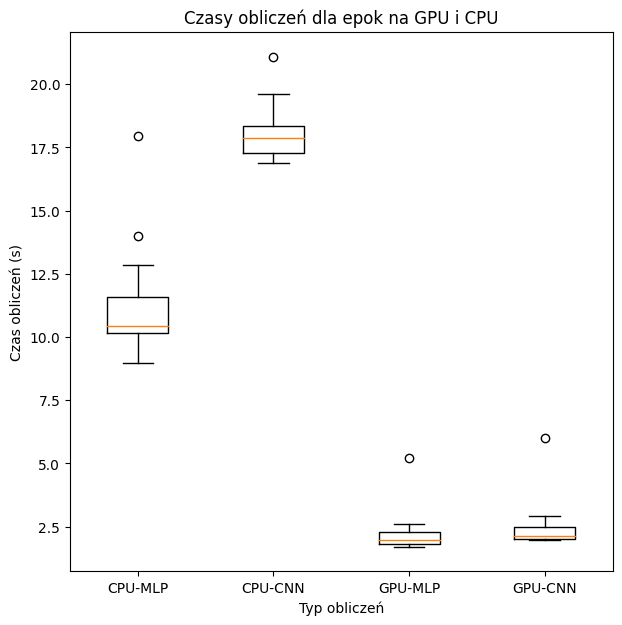

In [27]:
#TODO przedstaw czas obliczeń gpu_epoch_time, cpu_epoch_time na wykresie pudełkowym
import matplotlib.pyplot as plt

plt.boxplot([cpu_results[0], cpu_results[1], gpu_results[0], gpu_results[1]], labels=['CPU-MLP', 'CPU-CNN', 'GPU-MLP','GPU-CNN'])

plt.title('Czasy obliczeń dla epok na GPU i CPU')
plt.xlabel('Typ obliczeń')
plt.ylabel('Czas obliczeń (s)')

plt.show()

**Wnioski**

Wykorzystanie GPU do obliczeń pozwala na znaczne przyspieszenie procesu uczenia się modelu. Jest to szczególnie ważne w przypadku dużych zbiorów danych lub skomplikowanych modeli, gdzie szybkość obliczeń jest kluczowa.

CNN, dzięki swojej zdolności do wykrywania lokalnych wzorców i cech przestrzennych, osiąga lepszą jakość niż MLP, co czyni go bardziej odpowiednim wyborem dla problemów związanych z analizą obrazów.

W zależności od dostępnych zasobów obliczeniowych i wymagań dotyczących jakości modelu, istnieje potrzeba zrównoważenia między szybkością obliczeń a jakością modelu przy wyborze odpowiedniego środowiska wykonawczego i architektury sieci neuronowej.



